### Benchmark
compare the loop and vectorized implementation.

  * Loop through each node: [model/queue_class_ce170.py](model/queue_class_ce170.py)
  * Vectorized: [model/spatial_queue_array.py](model/spatial_queue_array.py)

In [1]:
import sys
import time 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
random.seed(0)
np.random.seed(0)

### profiler
#%load_ext line_profiler

### spatial queue model
sys.path.insert(0, '../../..')
sys.path.insert(0, '..')
import model.queue_class_ce170 as sq_loop
#import model.queue_class_ce170_separate as sq_loop_separate
import model.spatial_queue_array as sq_vect

In [10]:
### Read network and demand
case='new_fairfax' ### or new_fairfax
nodes_df = pd.read_csv('traffic_inputs/{}_nodes.csv'.format(case))
links_df = pd.read_csv('traffic_inputs/{}_links.csv'.format(case))
od_df = pd.read_csv('traffic_inputs/{}_ods_day.csv'.format(case))
#od_df = pd.concat([od_df]*100)

### these are done for the vectorized implementation
if case == 'berkeley':
    osmid2nid_dict = {getattr(n, 'node_osmid'): getattr(n, 'node_id') for n in nodes_df.itertuples()}
    od_df['origin_nid'] = od_df['origin_osmid'].map(osmid2nid_dict)
    od_df['destin_nid'] = od_df['destin_osmid'].map(osmid2nid_dict)
    special_nodes = {'first_priority':[], 'second_priority':[]}
if case == 'new_fairfax':
    special_nodes = {'first_priority':[], 'second_priority':[]}
    background_od = pd.read_csv('traffic_inputs/{}_ods_background.csv'.format(case))
    od_df = pd.concat([od_df, background_od]).sample(frac=1)
    #od_df = background_od.sample(frac=0.5)
    od_df = od_df[od_df['origin_nid']!=od_df['destin_nid']]
    od_df['departure_hour'] = od_df['departure_hour'].fillna(6)
    od_df['departure_quarter'] = od_df['departure_quarter'].fillna(0)
    od_df['departure_time'] = (
        od_df['departure_hour']-6)*3600 + od_df['departure_quarter']*900 
    nodes_df['node_id'] = nodes_df['new_nid'].astype(int)
    nodes_df['type'] = 'real'
    nodes_df['node_osmid'] = nodes_df['node_id']
print('# nodes {}, # links {}, # ods {}'.format(nodes_df.shape[0], links_df.shape[0], od_df.shape[0]))
display(nodes_df.tail(2))
display(links_df.tail(2))

/Users/bingyu/opt/anaconda3/envs/cities/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# nodes 206421, # links 507842, # ods 116160


,node_grp,lon,lat,new_nid,node_id,type,node_osmid
206419,g9998,-122.131677,38.230875,206419,206419,real,206419
206420,g9999,-122.607582,38.122272,206420,206420,real,206420


,start_node_id,end_node_id,nid_s_old,nid_e_old,length,lanes,type,capacity,maxmph,geometry,link_id
507840,99885,192503,116554,224223,1000.0,1000,vl_out,1000000,1000,"LINESTRING(-122.6079542 38.0005342, -122.5823 ...",507840
507841,119384,192503,139862,224223,1000.0,1000,vl_out,1000000,1000,"LINESTRING(-122.5811396 37.9866327, -122.5823 ...",507841


### This is the vectorized simulation.

In [4]:
# count the number of evacuees that have successfully reach their destination
def arrival_counts_vect(t, simulation, save_path):
    arrival_cnts = np.sum(simulation.agents.agents['agent_status']==-1)
    print('At {} seconds, {} evacuees successfully reached the destination'.format(t, arrival_cnts))
    if arrival_cnts == simulation.agents.agents.shape[0]:
        print("all agents arrive at destinations at time {} seconds.".format(t))
        return False
    with open(save_path, 'a') as t_stats_outfile:
        t_stats_outfile.write("{},{}".format(t, arrival_cnts) + "\n")
    return True

# write a csv file that contains the numbers of queuing and running vehicles on each link
def write_link_outputs_vect(simulation, save_path):
    link_output = simulation.network.links.loc[
        simulation.network.links['link_type'].isin(['real', 'virtual']), 
        ['link_id', 'queue', 'run', 'undeparted', 'length', 'geometry']].copy()
    link_output = link_output[
        (link_output['queue']>0) | (link_output['run']>0)
        | (link_output['undeparted']>0)
    ]
    link_output.to_csv(save_path, index=False)


### initialize simulation
simulation_vect = sq_vect.Simulation()
simulation_vect.initialize_simulation(nodes_df, links_df, od_df)

### specify some parameters
scenario_name = '{}_vect'.format(case)
t_end = 3600
arrival_output_path = 'traffic_outputs/{}/t_stats/arrivals_{}.csv'.format(case, scenario_name)

### run simulation and output results
with open(arrival_output_path, 'w') as t_stats_outfile:
    t_stats_outfile.write("t,arrival_count"+"\n")

# iterate through each time step
t_start_vect = time.time()
for t in range(t_end):
        
    # run the spatial-queue simulation for one step
    simulation_vect.run_one_step(t, reroute_frequency=None, special_nodes=special_nodes)

    # output time-step results every 100 seconds
    if t%1000 == 0:
        if not arrival_counts_vect(t, simulation_vect, arrival_output_path):
            break
        link_output_path = 'traffic_outputs/{}/link_stats/l{}_at_{}.csv'.format(case, scenario_name, t)
        #node_output_path = 'traffic_outputs/berkeley/node_stats/n{}_at_{}.csv'.format(scenario_name, t)
        write_link_outputs_vect(simulation_vect, link_output_path)
        #write_node_outputs(simulation_vect, node_output_path)
        print(t, time.time())

print(t, time.time())
print ("simulation completed")
t_end_vect = time.time()
print('Simulation took {}s'.format(t_end_vect - t_start_vect))
    

Agent IDs not specified; use sequential number.
At 0 seconds, 0 evacuees successfully reached the destination
0 1645819562.958213
At 1000 seconds, 1762 evacuees successfully reached the destination
1000 1645820142.5948548
At 2000 seconds, 4362 evacuees successfully reached the destination
2000 1645820591.3516579
At 3000 seconds, 6906 evacuees successfully reached the destination
3000 1645821057.657741
3599 1645821323.830533
simulation completed
Simulation took 1765.8138468265533s


### This is the unvectorized simulation.

In [11]:
# remove vehicles from the simulation if no path can be found for it
def remove_no_path_agents(simulation):
    cannot_find_path = []
    for vehicle_id, vehicle in simulation.all_agents.items():
        routing_status = vehicle.get_path( g=simulation.g )
        if routing_status == 'no_path_found':
            cannot_find_path.append(vehicle_id)

    for vehicle_id in cannot_find_path:
        del simulation.all_agents[vehicle_id]
      
    print('# o-d pairs whose paths cannot be found: {}'.format(len(cannot_find_path)))
    print('# o-d pairs/trips {}'.format(len(simulation.all_agents)))
    return simulation

# initialize the spatial-queue model
def init_sq_simulation(nodes_df, links_df, od_df):

    simulation = sq_loop.Simulation()
    simulation.create_network(nodes_df, links_df)
    simulation.create_demand(od_df)

    simulation = remove_no_path_agents(simulation)
    return simulation

# run the spatial-queue simulation for one time step
def single_step_sq_sim(simulation,t,reroute_frequency):
    ### load agents
    for agent_id, agent in simulation.all_agents.items(): 
        agent.load_trips(t)
        ### reroute
        if (t>0) and (t%reroute_frequency == 0):
            routing_status = agent.get_path( g=simulation.g )
    ### run link model
    for link_id, link in simulation.all_links.items():
        link.run_link_model(t)
    ### run node model
    node_ids_to_run = set([link.end_nid for link in simulation.all_links.values() if len(link.queue_veh)>0])
    for node_id in node_ids_to_run:
        node = simulation.all_nodes[node_id] 
        node.run_node_model(t)
    return simulation

# count the number of evacuees that have successfully reach their destination
def arrival_counts(t,simulation,save_path):
    arrival_cnts = np.sum([1 for a in simulation.all_agents.values() if a.status=='arr'])
    print('At {} seconds, {} evacuees successfully reached the destination, {}'.format(t, arrival_cnts, time.time()))
    if arrival_cnts == len(simulation.all_agents):
        print("all agents arrive at destinations at time {} seconds.".format(t))
        return False
    with open(save_path, 'a') as t_stats_outfile:
        t_stats_outfile.write("{},{}".format(t, arrival_cnts) + "\n")
    return True

# write a csv file that contains the numbers of queuing and running vehicles on each link
def write_link_outputs(simulation,save_path):
    link_output = pd.DataFrame(
        [(link.lid, len(link.queue_veh), len(link.run_veh), 
          np.round((len(link.queue_veh)+len(link.run_veh))/(link.length * link.lanes+0.00001)*100, 2), 
          link.geometry) for link in simulation.all_links.values() 
         #if link.ltype[0:2]!='vl'
        ], 
        columns=['link_id', 'queue_vehicle_count', 'run_vehicle_count', 'vehicle_per_100m', 'geometry'])
    link_output = link_output[(link_output['queue_vehicle_count']>0) | (link_output['run_vehicle_count']>0)].reset_index(drop=True)
    link_output.to_csv(save_path, index=False)

# write a csv file that contains the numbers of vehicles that have not departed and waiting at each node
def write_node_outputs(simulation,save_path):
    node_predepart = pd.DataFrame([(agent.cle, 1) for agent in simulation.all_agents.values() if (agent.status in [None, 'loaded'])], columns=['node_id', 'predepart_cnt']).groupby('node_id').agg({'predepart_cnt': np.sum}).reset_index()
    if node_predepart.shape[0]>0:
        node_predepart = node_predepart.merge(nodes_df[['node_id', 'lat', 'lon']], how='left', on='node_id')
        node_predepart.to_csv(save_path, index=False)

def spatial_queue_simulation(t_end,simulation,scenario_name,reroute_frequency):
    # paths 
    arrival_output_path = 'traffic_outputs/{}/t_stats/arrivals_{}.csv'.format(case, scenario_name)
    with open(arrival_output_path, 'w') as t_stats_outfile:
        t_stats_outfile.write("t,arrival_count"+"\n")

    t_start_loop = time.time()
    # iterate through each time step
    for t in range(t_end):

        # run the spatial-queue simulation for one step
        simulation = single_step_sq_sim(simulation,t,reroute_frequency)

        # output time-step results every 100 seconds
        if t%100 == 0:
            if not arrival_counts(t,simulation,arrival_output_path):
                break
            link_output_path = 'traffic_outputs/{}/link_stats/l{}_at_{}.csv'.format(case, scenario_name, t)
            node_output_path = 'traffic_outputs/{}/node_stats/n{}_at_{}.csv'.format(case, scenario_name, t)
            write_link_outputs(simulation,link_output_path)
            write_node_outputs(simulation,node_output_path)

    print ("simulation completed")
    t_end_loop = time.time()
    print("Simulation took {}s".format(t_end_loop-t_start_loop))
    return simulation

In [12]:
simulation = init_sq_simulation(nodes_df,links_df,od_df)
spatial_queue_simulation(1401, simulation, '{}_loop'.format(case), 36000)

# o-d pairs whose paths cannot be found: 12927
# o-d pairs/trips 103233
At 0 seconds, 0.0 evacuees successfully reached the destination, 1645826853.071358
At 100 seconds, 28 evacuees successfully reached the destination, 1645827046.006558
At 200 seconds, 112 evacuees successfully reached the destination, 1645827241.78203
At 300 seconds, 256 evacuees successfully reached the destination, 1645827430.369696
At 400 seconds, 449 evacuees successfully reached the destination, 1645827609.248009
At 500 seconds, 697 evacuees successfully reached the destination, 1645827785.222172
At 600 seconds, 1003 evacuees successfully reached the destination, 1645827950.138737
At 700 seconds, 1338 evacuees successfully reached the destination, 1645828116.3957162
At 800 seconds, 1764 evacuees successfully reached the destination, 1645828286.98115
At 900 seconds, 2182 evacuees successfully reached the destination, 1645828464.74982
At 1000 seconds, 2630 evacuees successfully reached the destination, 1645828638

### Unvectorized but separate the classes

In [4]:
# remove vehicles from the simulation if no path can be found for it
def remove_no_path_agents(simulation):
    cannot_find_path = []
    for vehicle_id, vehicle in simulation.all_agents.items():
        routing_status = vehicle.get_path( g=simulation.g )
        if routing_status == 'no_path_found':
            cannot_find_path.append(vehicle_id)

    for vehicle_id in cannot_find_path:
        del simulation.all_agents[vehicle_id]
      
    print('# o-d pairs whose paths cannot be found: {}'.format(len(cannot_find_path)))
    print('# o-d pairs/trips {}'.format(len(simulation.all_agents)))
    return simulation

# initialize the spatial-queue model
def init_sq_simulation(nodes_df, links_df, od_df):

    simulation = sq_loop_separate.Simulation()
    simulation.create_network(nodes_df, links_df)
    simulation.create_demand(od_df)

    simulation = remove_no_path_agents(simulation)
    return simulation

# run the spatial-queue simulation for one time step
def single_step_sq_sim(simulation,t,reroute_frequency):
    ### load agents
    for agent_id, agent in simulation.all_agents.items(): 
        agent.load_trips(t)
        ### reroute
        if (t>0) and (t%reroute_frequency == 0):
            routing_status = agent.get_path( g=simulation.g )
    ### run link model
    for link_id, link in simulation.all_links.items():
        simulation.all_agents = link.run_link_model(t, {'g': simulation.g, 'all_agents': simulation.all_agents})
    ### run node model
    node_ids_to_run = set([link.end_nid for link in simulation.all_links.values() if len(link.queue_veh)>0])
    for node_id in node_ids_to_run:
        node = simulation.all_nodes[node_id] 
        node.run_node_model(t)
    return simulation

# count the number of evacuees that have successfully reach their destination
def arrival_counts(t,simulation,save_path):
    arrival_cnts = np.sum([1 for a in simulation.all_agents.values() if a.status=='arr'])
    print('At {} seconds, {} evacuees successfully reached the destination'.format(t, arrival_cnts))
    if arrival_cnts == len(simulation.all_agents):
        print("all agents arrive at destinations at time {} seconds.".format(t))
        return False
    with open(save_path, 'a') as t_stats_outfile:
        t_stats_outfile.write("{},{}".format(t, arrival_cnts) + "\n")
    return True

# write a csv file that contains the numbers of queuing and running vehicles on each link
def write_link_outputs(simulation,save_path):
    link_output = pd.DataFrame(
        [(link.lid, len(link.queue_veh), len(link.run_veh), 
          np.round((len(link.queue_veh)+len(link.run_veh))/(link.length * link.lanes+0.00001)*100, 2), 
          link.geometry) for link in simulation.all_links.values() 
         #if link.ltype[0:2]!='vl'
        ], 
        columns=['link_id', 'queue_vehicle_count', 'run_vehicle_count', 'vehicle_per_100m', 'geometry'])
    link_output = link_output[(link_output['queue_vehicle_count']>0) | (link_output['run_vehicle_count']>0)].reset_index(drop=True)
    link_output.to_csv(save_path, index=False)

# write a csv file that contains the numbers of vehicles that have not departed and waiting at each node
def write_node_outputs(simulation,save_path):
    node_predepart = pd.DataFrame([(agent.cle, 1) for agent in simulation.all_agents.values() if (agent.status in [None, 'loaded'])], columns=['node_id', 'predepart_cnt']).groupby('node_id').agg({'predepart_cnt': np.sum}).reset_index()
    if node_predepart.shape[0]>0:
        node_predepart = node_predepart.merge(nodes_df[['node_id', 'lat', 'lon']], how='left', on='node_id')
        node_predepart.to_csv(save_path, index=False)

def spatial_queue_simulation(t_end,simulation,scenario_name,reroute_frequency):
    # paths 
    arrival_output_path = 'traffic_outputs/{}/t_stats/arrivals_{}.csv'.format(case, scenario_name)
    with open(arrival_output_path, 'w') as t_stats_outfile:
        t_stats_outfile.write("t,arrival_count"+"\n")

    t_start_loop = time.time()
    # iterate through each time step
    for t in range(t_end):

        # run the spatial-queue simulation for one step
        simulation = single_step_sq_sim(simulation,t,reroute_frequency)

        # output time-step results every 100 seconds
        if t%100 == 0:
            if not arrival_counts(t,simulation,arrival_output_path):
                break
            link_output_path = 'traffic_outputs/{}/link_stats/l{}_at_{}.csv'.format(case, scenario_name, t)
            node_output_path = 'traffic_outputs/{}/node_stats/n{}_at_{}.csv'.format(case, scenario_name, t)
            write_link_outputs(simulation,link_output_path)
            write_node_outputs(simulation,node_output_path)

    print ("simulation completed")
    t_end_loop = time.time()
    print("Simulation took {}s".format(t_end_loop-t_start_loop))
    return simulation

In [5]:
simulation = init_sq_simulation(nodes_df,links_df,od_df)
spatial_queue_simulation(1, simulation, '{}_loop_separate'.format(case), 36000)
#%lprun -f spatial_queue_simulation(1, simulation, '{}_loop'.format(case), 36000)

# o-d pairs whose paths cannot be found: 0
# o-d pairs/trips 3947


### Plot results

,t,arrival_count
10,1000,1637.0
11,1100,1789.0
12,1200,1929.0
13,1300,2064.0
14,1400,2196.0


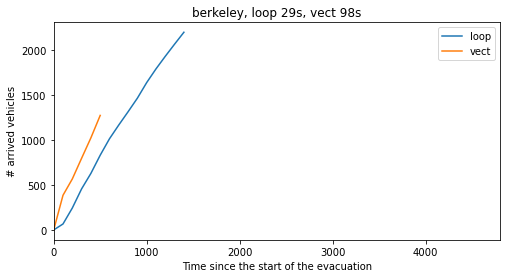

In [6]:
### plot the arrival curve
fig, ax = plt.subplots(figsize=(8, 4))

### base scenario arrival
t_stats_loop_df = pd.read_csv('traffic_outputs/{}/t_stats/arrivals_{}_loop.csv'.format(case, case))
ax.plot(t_stats_loop_df['t'], t_stats_loop_df['arrival_count'], label='loop')
display(t_stats_loop_df.tail())

t_stats_vect_df = pd.read_csv('traffic_outputs/{}/t_stats/arrivals_{}_vect.csv'.format(case, case))
ax.plot(t_stats_vect_df['t'], t_stats_vect_df['arrival_count'], label='vect')

ax.set_xlabel('Time since the start of the evacuation')
ax.set_ylabel('# arrived vehicles')
ax.set_xlim([0, 4800])
plt.legend()
plt.title('{}, loop {}s, vect {}s'.format(case, 29, 98))
plt.show()

In [16]:
display(links_df.head(1))
links_df2 = links_df.copy()
links_df2['link_id'] = links_df2['link_id'].astype(str)
for t in range(60000, 70200, 100):
    link_results = pd.read_csv('traffic_outputs/fairfax/link_stats/lfairfax_vect_at_{}.csv'.format(t))
    display(link_results[link_results['link_id']=='13289'])
    #link_results['link_id'] = link_results['link_id'].astype(str)
    #link_results = pd.merge(link_results, links_df2[['link_id', 'lanes']], how='left', on='link_id')
    #link_results['queue_density'] = link_results['queue']/(link_results['length']*link_results['lanes'])
    #link_results.to_csv('traffic_outputs/fairfax/link_stats/lfairfax_vect_at_{}_lanes.csv'.format(t))

,start_node_id,end_node_id,nid_s_old,nid_e_old,length,lanes,type,capacity,maxmph,geometry,link_id
0,0,2,0,2,175.637,1,residential,950,25,"LINESTRING(-122.7694487 38.4353358, -122.76926...",0


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry


,link_id,queue,run,undeparted,length,geometry
